In [2]:
import pandas as pd
import numpy as np

## Notes:
1. experiment with feature selection
2. Implement Neural Nets
3. Use PCA and check if it helps
4. Feature extraction??

Best so far (using r2):  
LinearRegression                                         : ~0.84
RandomForestRegresson(max_features=2,n_estimators = 200) : ~0.83

#### Structure:
1. Big Pic
2. Get Data
3. Discovery and visualisation
4. Data processing 
5. Model selection
6. Fine Tuning
7. Summary

## Get data


In [3]:
ampg = pd.read_csv('datasets/ampg/auto-mpg.csv')
ampg['horsepower'] = pd.to_numeric(ampg['horsepower'],errors='coerce')#, downcast='integer')
ampg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


## Discovery and visualization

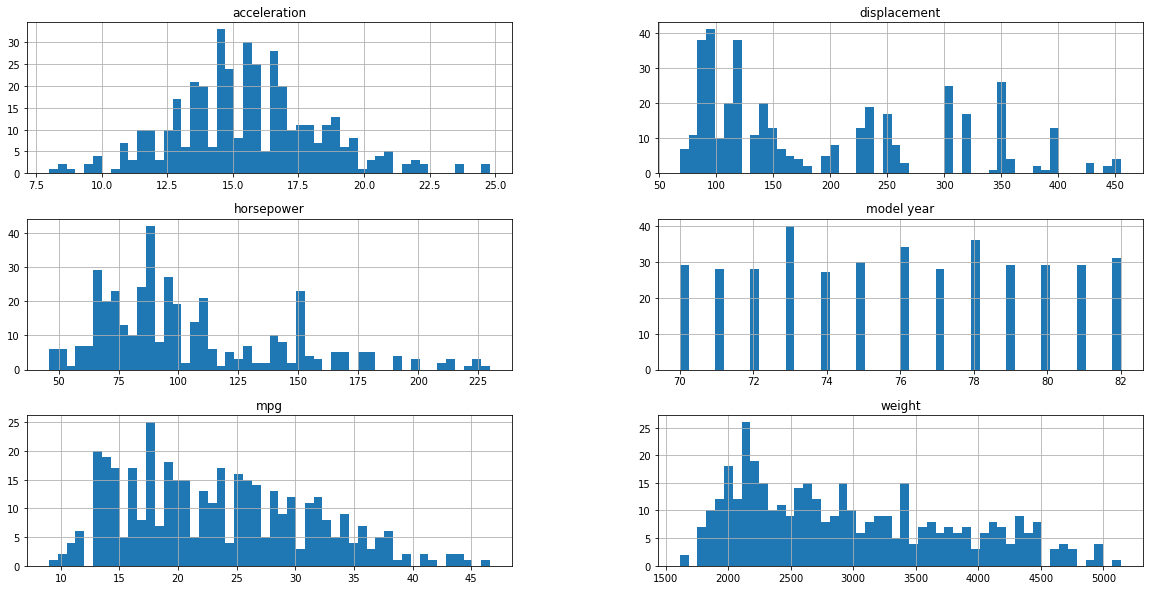

In [4]:
ampg.drop(columns=['car name','origin','cylinders']).hist(bins=50, figsize=(20,10))
print()

### Missing values

In [5]:
ampg[ampg.isnull().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,NaN,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,1,amc concord dl


In [6]:
# Missind values
missing_data=[32,126,330,336,354,374] 
# ampg = ampg.dropna(subset=["horsepower"])

#another option is to use KNNImputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(ampg.drop(columns=['car name','model year','origin']))
ampg['horsepower'] = imputed[:,3]
ampg.iloc[missing_data,:]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,62.0,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,107.6,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,62.4,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,112.8,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,76.0,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,88.2,3035,20.5,82,1,amc concord dl


### Feature extraction

In [7]:
# Split into categories by Horsepower
ampg["HP_cat"] = pd.cut(ampg["horsepower"],
                               bins=[0, 70, 90, 130, np.inf],
                               labels=[1, 2, 3, 4])

ampg['HP/kg'] = ampg['horsepower']/ampg['weight'] 
ampg.drop(columns=['model year','origin']).groupby('HP_cat',).mean()

,mpg,cylinders,displacement,horsepower,weight,acceleration,HP/kg
HP_cat,,,,,,,
1,33.646575,4.013699,91.123288,63.101370,2027.013699,17.863014,0.031404
2,26.443697,4.386555,138.105042,82.354622,2563.773109,16.576471,0.032800
3,21.040870,5.513043,193.382609,105.412174,3055.182609,15.449565,0.035137
4,14.682418,7.934066,347.890110,164.087912,4151.890110,12.558242,0.039787


In [8]:
ampg["HP_cat"].value_counts().sort_index()

1     73
2    119
3    115
4     91
Name: HP_cat, dtype: int64

### Separate the test set

In [9]:
# 
from sklearn.model_selection import StratifiedShuffleSplit

ampg = ampg.reset_index()
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4,)
for train_index, test_index in split.split(ampg, ampg["HP_cat"]):
    strat_train_set = ampg.loc[train_index]
    strat_test_set = ampg.loc[test_index]

In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(ampg, test_size=0.4)

### Visualize

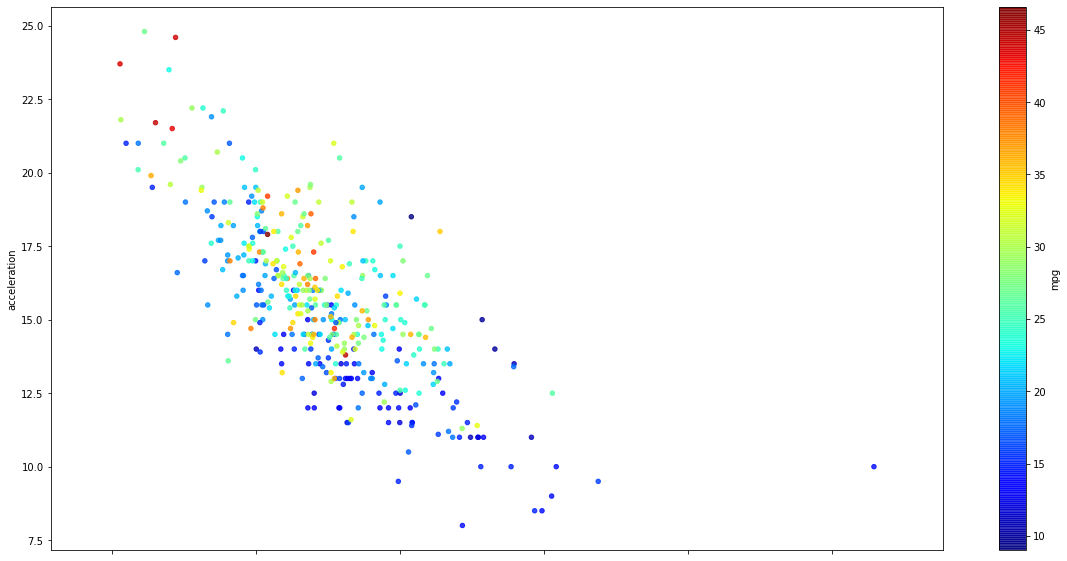

In [11]:
import matplotlib.pyplot as plt
ampg.plot(kind="scatter", x="HP/kg", y="acceleration",c='mpg',cmap=plt.get_cmap('jet'),alpha=0.8,figsize=(20,10))

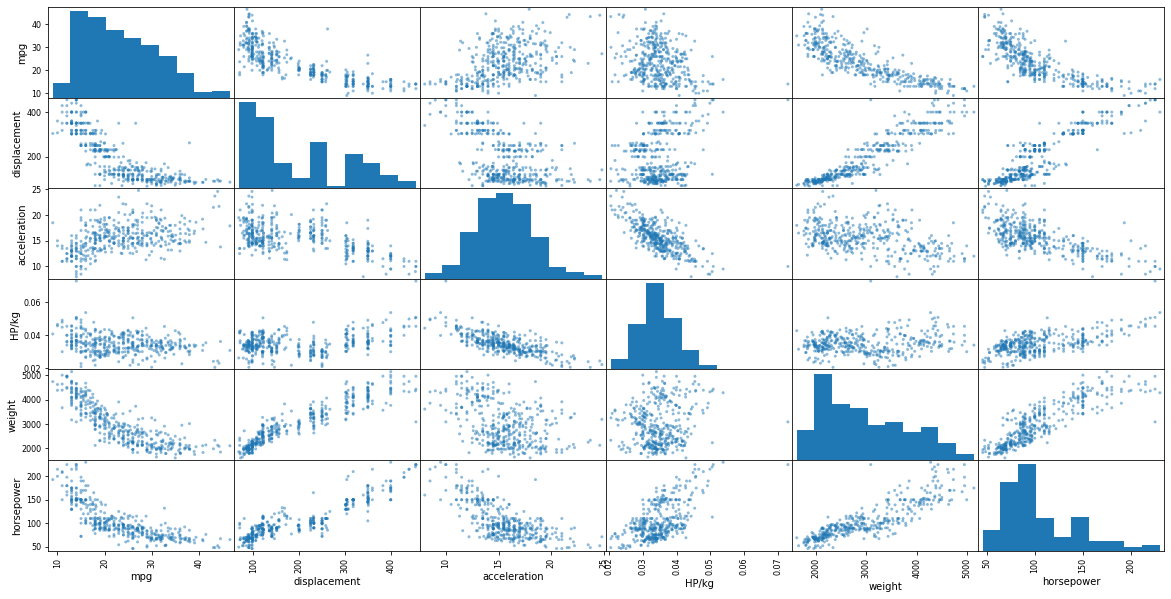

In [30]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
# attributes = ["mpg", "displacement", "horsepower","weight","model year"]
attributes = ["mpg", "displacement",'acceleration','HP/kg','weight','horsepower']
scatter_matrix(ampg[attributes], figsize=(20, 10))
print()

### Correlations:

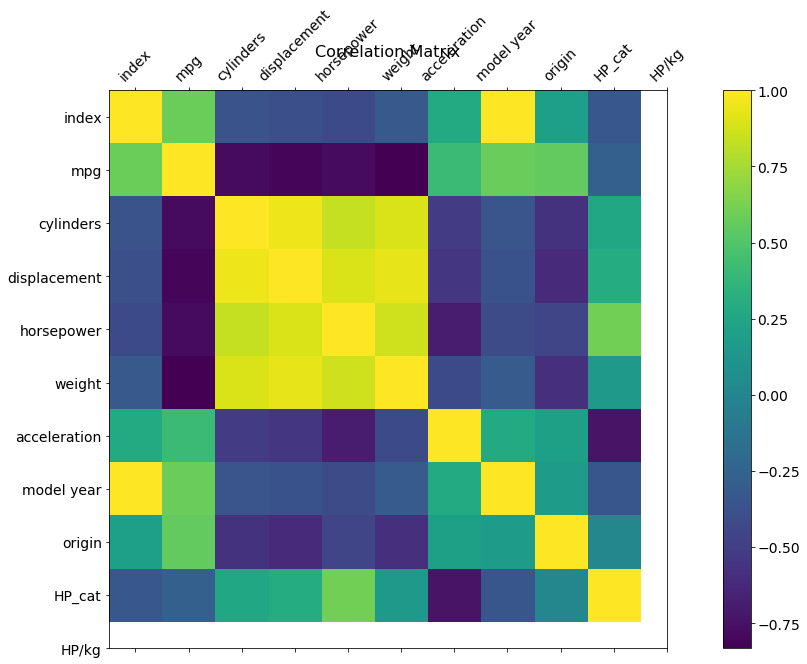

In [13]:
f = plt.figure(figsize=(20, 10))
df = ampg.drop(columns=['car name'])
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### Prepare data

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
cars = strat_train_set.drop('mpg',axis=1)
cars_mpgs = strat_train_set['mpg']
# cars_num = cars.iloc[:,[0,2,3,4,5]] 
# cars_cat = cars.iloc[:,[1,6,7,9]] 
cars.columns

Index(['index', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name', 'HP_cat', 'HP/kg'],
      dtype='object')

In [15]:
cars_mpgs

127    19.0
302    34.5
116    16.0
294    34.1
237    30.5
       ... 
230    15.5
368    27.0
393    27.0
61     21.0
32     25.0
Name: mpg, Length: 238, dtype: float64

In [16]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

features = {
    'OneHot' : ['model year'],#'origin'],
    'Ordinal': ['cylinders','HP_cat'],
    'Scaler' : ['displacement','weight','acceleration','HP/kg']
}

pipe = ColumnTransformer([
    ('OneHot',OneHotEncoder(),features['OneHot']),
    ('Ordinal',OrdinalEncoder(),features['Ordinal']),
    ('Scaler',MinMaxScaler(),features['Scaler'])
])
encoder = OneHotEncoder()
encoder.fit(cars[features['OneHot']])
names = list(encoder.get_feature_names(features['OneHot']))
cars_transformed = pipe.fit_transform(cars)
names+=features['Ordinal']+features['Scaler']
pd.DataFrame(cars_transformed,columns=names)


,model year_70,model year_71,model year_72,model year_73,model year_74,model year_75,model year_76,model year_77,model year_78,model year_79,model year_80,model year_81,model year_82,cylinders,HP_cat,displacement,weight,acceleration,HP/kg
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.423773,0.380615,0.476190,0.417988
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.095607,0.158688,0.410714,0.360285
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.857881,0.787530,0.089286,1.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.046512,0.106974,0.428571,0.370942
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.077519,0.129433,0.535714,0.304734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.728682,0.754137,0.202381,0.609416
234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.113695,0.303487,0.630952,0.383671
235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.186047,0.347813,0.452381,0.307982
236,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.139535,0.181147,0.505952,0.543590


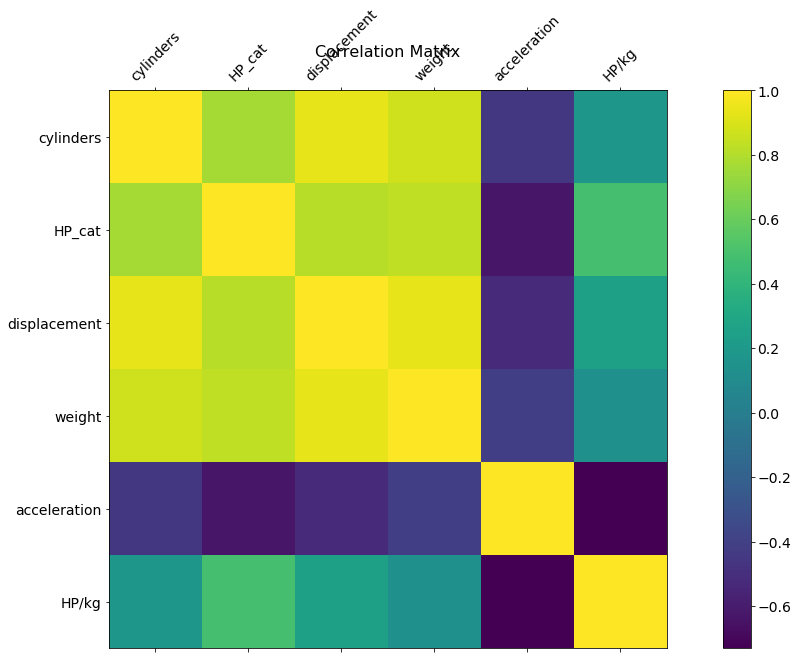

In [28]:

f = plt.figure(figsize=(20, 10))
df = pd.DataFrame(cars_transformed[:,13:],columns=names[13:]) 
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

#### Comparing different models

In [18]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def display_scores(scores):
        print("Scores:", scores)
        print("Mean:", scores.mean())
            
def do(df,estimator):
    trans = df.copy()
    est = estimator
    est.fit(trans,cars_mpgs )

    # let's try the full preprocessing pipeline on a few training instances
    some_data = cars.iloc[:5]
    some_labels = cars_mpgs.iloc[:5]
    some_data_prepared = pipe.transform(some_data)
    
    print(str(type(estimator).__name__).center(100,'='))
    print("Predictions:", est.predict(some_data_prepared))
    print("Labels:", list(some_labels))
    
    predictions = est.predict(some_data_prepared)
    lin_mse = mean_squared_error(some_labels, predictions)
    lin_rmse = np.sqrt(lin_mse)
    lin_mae = mean_absolute_error(some_labels, predictions)
    scores = cross_val_score(est, trans, cars_mpgs,
                         scoring="r2", cv=10) 
    
#     print('rmse:',lin_rmse)
#     print('mae:',lin_mae) 
    print(100*'-')
    display_scores(scores)
    
    print(100*'=','\n')

df=cars_transformed 
do(df,DecisionTreeRegressor())
do(df,SVR(kernel='linear'))
do(df,LinearRegression())
do(df,RandomForestRegressor())


=======================================DecisionTreeRegressor========================================
Predictions: [19.  34.5 16.  34.1 30.5]
Labels: [19.0, 34.5, 16.0, 34.1, 30.5]
----------------------------------------------------------------------------------------------------
Scores: [0.36466851 0.73895207 0.74094698 0.70430518 0.85577007 0.53584984
 0.60879666 0.62597017 0.41804823 0.67690495]
Mean: 0.6270212663976654

================================================SVR=================================================
Predictions: [20.34525431 32.40375264 14.62480251 32.69105991 30.40036161]
Labels: [19.0, 34.5, 16.0, 34.1, 30.5]
----------------------------------------------------------------------------------------------------
Scores: [0.83984842 0.781228   0.84788631 0.88779281 0.81855756 0.75520435
 0.7269267  0.85715801 0.67866009 0.78944941]
Mean: 0.7982711660807352

==========================================LinearRegression==========================================
Predicti

In [19]:
# #Keys for cross validaion
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [100,200,300], 'max_features': [2,4]}
  ]

reg = RandomForestRegressor()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(reg, param_grid, cv=5,
                           scoring='r2',
                           return_train_score=True)
grid_search.fit(cars_transformed,cars_mpgs)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [21]:
mf,ne = grid_search.best_params_.values()
print(mf,ne)

2 200


In [22]:
feature_importances = grid_search.best_estimator_.feature_importances_
for v,f in zip(feature_importances,names):
    print(v,f)

0.00783612136327851 model year_70
0.006534601718515247 model year_71
0.010173121431557599 model year_72
0.0189409218263231 model year_73
0.0036157652127694045 model year_74
0.006501136095297757 model year_75
0.003453157611663986 model year_76
0.002798432326679924 model year_77
0.009290099833335601 model year_78
0.008096684814931842 model year_79
0.026824146893132946 model year_80
0.013341655306263212 model year_81
0.026719152355783905 model year_82
0.14040476951538308 cylinders
0.13793735948454805 HP_cat
0.23542171970839953 displacement
0.19859740165055123 weight
0.07941900280717012 acceleration
0.06409475004441498 HP/kg


In [23]:
do(cars_transformed,RandomForestRegressor(max_features=mf,n_estimators=ne))
do(cars_transformed,RandomForestRegressor())


=======================================RandomForestRegressor========================================
Predictions: [19.247  34.4575 14.755  34.6075 30.8265]
Labels: [19.0, 34.5, 16.0, 34.1, 30.5]
----------------------------------------------------------------------------------------------------
Scores: [0.85720554 0.78554117 0.86264722 0.83906382 0.87409664 0.7379962
 0.77554111 0.83378614 0.60978826 0.85620852]
Mean: 0.8031874624278412

=======================================RandomForestRegressor========================================
Predictions: [19.219 34.176 15.01  34.255 31.466]
Labels: [19.0, 34.5, 16.0, 34.1, 30.5]
----------------------------------------------------------------------------------------------------
Scores: [0.85374955 0.76597265 0.83931975 0.81407312 0.88398838 0.77928092
 0.63564824 0.78126353 0.52902005 0.8046652 ]
Mean: 0.7686981370306663



In [24]:
crossValRes = grid_search.cv_results_
for mean_score, params in zip(crossValRes["mean_test_score"], crossValRes["params"]):
    print(np.sqrt(mean_score), params)

0.8869558098746838 {'max_features': 2, 'n_estimators': 100}
0.8914357306183992 {'max_features': 2, 'n_estimators': 200}
0.8886116695775111 {'max_features': 2, 'n_estimators': 300}
0.8788108209771158 {'max_features': 4, 'n_estimators': 100}
0.8781535646085954 {'max_features': 4, 'n_estimators': 200}
0.8789911398416456 {'max_features': 4, 'n_estimators': 300}


In [25]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.172325,0.008304,0.010754,0.001446,2,100,"{'max_features': 2, 'n_estimators': 100}",0.795975,0.850124,0.807072,...,0.786691,0.062769,3,0.970225,0.968666,0.974066,0.972543,0.976877,0.972475,0.002880
1,0.319364,0.037434,0.018052,0.001999,2,200,"{'max_features': 2, 'n_estimators': 200}",0.807886,0.855081,0.802807,...,0.794658,0.059533,1,0.972171,0.971714,0.972505,0.970908,0.976160,0.972692,0.001815
2,0.446852,0.045692,0.023131,0.001594,2,300,"{'max_features': 2, 'n_estimators': 300}",0.805624,0.853580,0.803037,...,0.789631,0.064635,2,0.973166,0.973069,0.972740,0.974014,0.976836,0.973965,0.001496
3,0.138903,0.001844,0.008177,0.000482,4,100,"{'max_features': 4, 'n_estimators': 100}",0.809930,0.846963,0.794406,...,0.772308,0.076361,5,0.967087,0.967674,0.966673,0.969692,0.973253,0.968876,0.002422
4,0.283328,0.008653,0.015552,0.000705,4,200,"{'max_features': 4, 'n_estimators': 200}",0.789642,0.838053,0.802035,...,0.771154,0.072066,6,0.970547,0.970370,0.970952,0.972857,0.973236,0.971593,0.001208
5,0.406355,0.007399,0.022119,0.001279,4,300,"{'max_features': 4, 'n_estimators': 300}",0.793934,0.851179,0.803849,...,0.772625,0.078583,4,0.970949,0.971810,0.972766,0.973500,0.974470,0.972699,0.001236


In [26]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor()
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='r2')
rnd_search.fit(cars_transformed,cars_mpgs)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [27]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

0.8738289157365086 {'max_features': 4, 'n_estimators': 197}
0.8865414191207938 {'max_features': 2, 'n_estimators': 29}
0.8900526808350048 {'max_features': 2, 'n_estimators': 118}
0.885988693330433 {'max_features': 3, 'n_estimators': 171}
0.884524267381713 {'max_features': 3, 'n_estimators': 158}
0.8639797271257452 {'max_features': 7, 'n_estimators': 30}
0.8704901332782682 {'max_features': 6, 'n_estimators': 98}
0.8884391964931907 {'max_features': 2, 'n_estimators': 92}
0.8714558968775501 {'max_features': 4, 'n_estimators': 89}
0.867893583093778 {'max_features': 6, 'n_estimators': 38}
